# Well-Mixed Reaction Systems

The simulation script described in this chapter is available at [STEPS_Example repository](https://github.com/CNS-OIST/STEPS_Example/blob/master/user_manual/source/well_mixed.ipynb).

In this chapter, we'll use some simple classical reaction systems as examples
to introduce the basics of using STEPS. More specifically, we'll focus on reaction
systems that occur in a single, well-mixed reaction volume. The topics presented
in later chapters (such as surface-volume interactions, diffusion, 3D environments,
etc) will build on the material presented in this chapter.

In our first STEPS simulation, we'll be working with the following simple system,
which consists of a single reversible reaction:

\begin{equation}
    A+B\underset{{k_{b}}}{\overset{{k_{f}}}{{\rightleftarrows}}}C
\end{equation}

with 'forward' and 'backward' reaction constants $k_{f}$ and $k_{b}$,
respectively.


## Model Specification

The first thing we need to do, is to write some Python code that “passes”
this equation on to STEPS. This is called model specification, which in
STEPS consists of building a hierarchy of Python objects that list the species
occurring in your model, their relevant chemical and physical properties and
their interactions. As explained in the chapter introduction, here we deal only
with sets of reaction rules that occur together within one single chemical volume.

### Model container

The first step in model specification is to import package [steps.model](API_model.rst#steps.model).
This package contains all the definitions of the objects and functions you need
to describe the physics and chemistry of your model within STEPS. This entire
package has been written in c++ and exposed to Python through SWIG (Simplified
Wrapper and Interface Generator) and Cython, like most packages in STEPS. We import the package
using an alias, smodel, to reduce the required amount of typing (a common
convention in Python):


In [1]:
import steps.model as smodel

`smodel` now refers to the [steps.model](API_model.rst#steps.model) Python module containing the class
definitions.

Next, we're going to create a top-level container object for our
model ([steps.model.Model](API_model.rst#steps.model.Model)). This top level container is required for
all simulations in STEPS but itself does not contain much information and
merely acts as a hub that allows the other objects in the model specification
to reference each other. In the code listing below, we store our Model object
in variable `mdl`. When you create an object in Python information inside the
parenthesis is passed onto the class constructor. Each constructor requires
specific information, though some information can be omitted and will be given
default values, as we will see. However, for a [steps.model.Model](API_model.rst#steps.model.Model) object, the
constructor does not require any information at all:


In [2]:
mdl = smodel.Model()

### Species

Our next task is to enumerate all the chemical species that can occur in the model.
This means creating a number of objects of type [steps.model.Spec](API_model.rst#steps.model.Spec) and passing them
on to the [steps.model.Model](API_model.rst#steps.model.Model) container. For our simple reaction the above equation,
we create
three [steps.model.Spec](API_model.rst#steps.model.Spec) objects (`molA`, `molB`, and `molC`) corresponding to our
three chemical species:


In [3]:
molA = smodel.Spec('molA', mdl)
molB = smodel.Spec('molB', mdl)
molC = smodel.Spec('molC', mdl)

The initializer of class [steps.model.Spec](API_model.rst#steps.model.Spec) requires two arguments: first an
identifier string that can be used later on to refer to this object. This
identifier string has to be unique among all species objects. It's important
to distinguish between the Python variable we use to store the reference to
the newly created object on the one hand (e.g. `molA`), and the identifier
string on the other (e.g. 'molA'). In this example they bear the same name,
but this is not necessary. These identifier strings are a common requirement
for STEPS objects at this level and we will see when and how they are necessary
later in this chapter, when describing geometry and performing simulations with
our model.

We should note at this point that our object reference variables should be
named differently also, though Python will allow you to reuse the same name
(one could even use the same name to reference objects of different type because
a variable in Python does not have to reference a specific type, as is the case
in c++ for example). So this, for example, does not result in an error in Python:


In [4]:
spec = smodel.Spec('mol1', mdl)
spec = smodel.Spec('mol2', mdl)

and since the identifier strings are different this is not a STEPS error either.
However, in the above code in the first line `spec` at first references the
'molA' object, but in the second line the object `spec` references changes
to the 'molB' object, and the reference to the 'molA' object is lost.
These object references are required when defining the species' interactions,
as we will see, so as a rule in STEPS all variables should be given a unique
name so that no object references are lost. Actually, we could use container
methods to return references to objects, but let's keep things simple for now.

The second argument in the [steps.model.Spec](API_model.rst#steps.model.Spec) initializer is an object reference
to the model we just created (stored in variable `mdl`). This will allow the [steps.model.Spec](API_model.rst#steps.model.Spec)
initializer to add itself to the [steps.model.Model](API_model.rst#steps.model.Model) container.

### Volume System

Next, we will create a *volume system*:


In [5]:
vsys = smodel.Volsys('vsys', mdl)

Volume systems (objects of class [steps.model.Volsys](API_model.rst#steps.model.Volsys)) are container
objects that group a number of stoichiometric reaction rules
(in later chapters we'll see how diffusion rules can also be added
to these volume systems). The user has the option of grouping all
reactions in the entire system into one single big volume system,
or using multiple volume systems to organize reaction rules that
belong together. The second option may be preferred for larger models,
but for our simple example we only require one volume system.

The arguments for the [steps.model.Volsys](API_model.rst#steps.model.Volsys) initializer are the same
as for [steps.model.Spec](API_model.rst#steps.model.Spec):
The first argument must be an identifier string, which can be used
for future referencing. This identifier must be unique among all volume
systems in the model. The second argument is the reference to the [steps.model.Model](API_model.rst#steps.model.Model)
parent object of which this [steps.model.Volsys](API_model.rst#steps.model.Volsys) will be a child.

### Reactions

Finally, we need to create the reaction rules themselves.
In STEPS a single reversible reaction has to be regarded as two separate
reaction rules; the first rule corresponding to the _forward_ reaction and
the second rule to the _backward_ reaction. So for our simple model in
the above equation , we have to create two objects of class [steps.model.Reac](API_model.rst#steps.model.Reac)
and add them to the [steps.model.Volsys](API_model.rst#steps.model.Volsys) object we just created:


In [6]:
kreac_f = smodel.Reac('kreac_f', vsys, lhs=[molA, molB], rhs=[molC], kcst=0.3e6)
kreac_b = smodel.Reac('kreac_b', vsys, lhs=[molC], rhs=[molA, molB])
kreac_b.kcst = 0.7

The initializer for [steps.model.Reac](API_model.rst#steps.model.Reac) can be provided with a bit more information than the
initializers for the other objects until now. Aside from the required identifier string (which is checked
to be unique among all reactions in all volume systems) and a required reference
to the [steps.model.Volsys](API_model.rst#steps.model.Volsys) object to which this reaction will be added, we can also specify
reaction stoichiometry at this stage (alternatively we can create the object with
the minimum information and set the stoichiometry with object methods). This
stoichiometry is specified by two Python lists:

* A list called `lhs`, which gives the left-hand side of the stoichiometry
  (i.e. the reactants). If a reactant occurs more than once, as can be the
  case in e.g. a dimerization reaction, the [steps.model.Spec](API_model.rst#steps.model.Spec) object has to be listed the
  required number of times.

* A list called `rhs`, which gives the right hand side of the stoichiometry
  (i.e. the reaction products). The same remarks that applied for parameter
  `lhs` apply here.

The lists must contain references to the required [steps.model.Spec](API_model.rst#steps.model.Spec) objects
(and not identifier strings), so we can see why it was important
not to lose these object references when we created our [steps.model.Spec](API_model.rst#steps.model.Spec) objects.
Both lists can also be empty e.g. `lhs=[]` or `rhs=[]` (this is the default
behavior if lists are not supplied to the constructor, but can be changed
with object methods `setLHS` and `setRHS`). Care should be used in the case of
empty lists because either situation could break physical laws such as the
conservation of mass, although they are available because they can be useful
for some simulation approximations. If the left hand side is empty, we have a
zero order reaction that acts as a source, i.e. it creates molecules “out of
thin air”. If the right hand side is empty, we have a sink reaction that
merely destroys molecules. Obviously, within one single reaction rule,
it doesn't make sense to set both `lhs` and `rhs` to an empty list.

We can also already set the default rate constants for both the forward
and backward reaction, by manipulating the `kcst` property of the Reac objects.
As shown above these rate constants can be initialized as a parameter during
object construction, or by using object methods after the object has been
created, which is common to many properties of objects in STEPS. **Note**: *This is an example of an object property:* `kcst` *is a property of  our* `Reac` *object. In this example* `kreac_f.kcst = 0.3e6` *is an indirect call  to object method* `kreac_f.setKcst(0.3e6)`. *For more information on available  property functions see* [API References](API_ref.ipynb#API_ref).


These rate constants can also be changed later on during the simulation, but values
given here will be used as default values when a simulation state is initialized.
*Generally speaking, physical constants in STEPS must be specified in SI units*.
However, the s.i derived unit for volume is the cubic meter, which means that the s.i derived unit for concentration is mole per cubic meter, and reaction constants would be based on cubic meters, i.e. a second order reaction constant should have units of metres cubed per mole-second ($m^{3}\left(mol.s\right)^{-1}$). However, the convention in chemical kinetics is to base reaction parameters on Molar units (M = mol/litre) (i.e. based on the litre rather than the cubic metre) and this convention is followed in STEPS. The actual interpretation of the unit of a reaction rule depends on the order of that reaction.


In other words, it depends on the number of species in the left hand side. **The constant for a zero order reaction in STEPS** **has units** $M.s^{-1}$; **for a first order reaction rule has units** $s^{-1}$; **for a second order reaction the units are** $\left(M.s\right)^{-1}$; **for a third order reaction** $\left(M^{2}.s\right)^{-1}$; and so on (while there is no upper limit on the order of the reaction when working with Reac objects within
the context of package steps.model, STEPS simulators will not deal with any
reaction rule that has an order larger than 4). These units are not strictly s.i. units, however **all parameters, other than reactions constants, in STEPS must be given in base or derived s.i. units**, which includes the unit of $m^{3}$ for volume. **Note**: *The units for a zero-order reaction have changed from previous versions of STEPS (*$s^{-1}$*)
   so as to follow convention. Zero-order reactions are NOT permitted on membranes (surface
   reactions, see later chapters) due to the ambiguity of the interpretation of the units.*

Finally, the full Python code of our model description looks like this:


In [7]:
import steps.model as smodel
mdl = smodel.Model()
molA = smodel.Spec('molA', mdl)
molB = smodel.Spec('molB', mdl)
molC = smodel.Spec('molC', mdl)
volsys = smodel.Volsys('vsys', mdl)
kreac_f = smodel.Reac('kreac_f', volsys, lhs=[molA, molB], rhs=[molC], kcst = 0.3e6)
kreac_b = smodel.Reac('kreac_b', volsys, lhs=[molC], rhs=[molA, molB])
kreac_b.kcst = 0.7

Notice that we have said nothing about the actual geometry of our model at
this point, nor have we said anything related to the simulation itself
(initial conditions, special events during the simulation, etc).
We have just created a hierarchy of Python objects that describes
the interactions between chemical species and we have done this on a
rather abstract level.

## Preparing geometry for well-mixed simulation

Before we can start doing simulations, we need to say something about
the environment in which our reactions will occur. Specifically, we need
to describe the volume compartments in which reactions take place, and sometimes
also the surface patches around or in between these compartments (patches are described in more detail in the [next chapter](ip3.ipynb)). We then link
each of these compartments with one or more of the volume systems defined
in the kinetic model, in a process called annotation. There are currently
two types of geometry that can be specified in STEPS:

1. *Well-mixed geometry*. In this type of geometry description, compartments are described
   only by their volume in cubic meters and patches by their area in
   square meters and connectivity to compartments. Nothing is said
   about the actual shape.

2. *Tetrahedral mesh geometry*. In this type of geometry, a compartment is a collection of 3D tetrahedral
   voxels and a patch is a 2D section between compartments composed of
   triangular surface connecting tetrahedrons.

We will talk about tetrahedral meshes (and their relationship with
well-mixed geometry) in the chapter on [Simulating Diffusion in Volumes](diffusion.ipynb#diffusion).
In this chapter, however, we will restrict ourselves to well-mixed geometry,
because we will only use the well-mixed stochastic solver. Specifying a
well-mixed compartment that can be used together with the kinetic model
from the previous section is very easy. First, need we to import the STEPS
module that contains the objects used to define the geometry, namely [steps.geom](API_geom.rst#steps.geom):


In [8]:
import steps.geom as swm

Like before we give the [steps.geom](API_geom.rst#steps.geom) module an alias `swm`, simply to reduce later
typing. Next we generate a parent container object, that will collect and store
the actual compartments. The purpose of this object is in many ways similar to
the purpose of the [steps.model.Model](API_model.rst#steps.model.Model) object we discussed in the previous section,
and the constructor does not require any information:


In [9]:
wmgeom = swm.Geom()

Finally, the actual compartment we need for simulating our model must be created:


In [10]:
comp = swm.Comp('comp', wmgeom)
comp.addVolsys('vsys')
comp.setVol(1.6667e-21)

Since our model is very simple, we only create one compartment, an object of
type [steps.geom.Comp](API_geom.rst#steps.geom.Comp), and we store it in the variable called `comp`.
The initializer takes two arguments here: first a unique identifier string
(that will once again be used later on, during actual simulation) and a
reference to the container object. Since we only have one compartment,
we use the rather unimaginative identifier `comp`.

The second line corresponds to the annotation, which in this case is very simple.
It links the compartment we just created with a volume system that carries the
identifier 'vsys'. At this stage, only the string is stored in the Comp object.
In other words, STEPS makes no attempt to resolve the link by searching for a
[steps.model.Volsys](API_model.rst#steps.model.Volsys) object that has the identifier 'vsys'. In fact, STEPS
couldn't resolve the link at this point, because the kinetic model and the
geometric model remain completely separated in memory. They will remain
separated until the time we create an actual simulation; that is the point
where these cross references between kinetic model and geometry will be resolved.

This “workflow” enables us to build several kinetic model descriptions and geometry
descriptions separately, and put them together as needed for simulation. The only
requirement for any combination of kinetic model and geometry to work is that
**the volume systems referenced from the geometry have been defined in the
kinetic model**. An error will result when creating the simulation object
(which we will do next) if any compartment contains a reference to a volume
system that is unknown in the model description.

The third line sets the volume of the compartment. Once again, SI units must be
used, meaning that the volume is specified in $m^{\text{3}}$. The volume of
compartment 'comp' therefore has a volume of $1.6667\cdot10^{-3}\mu m^{3}$.
This parameter can be set in the [steps.geom.Comp](API_geom.rst#steps.geom.Comp) object initializer, explicitly with the
`setVol` method (as above), or with the property function `vol` (i.e.
`comp.vol = 1.667e-21`).

## Simulation with `Wmdirect`

With all this in place, we can finally start performing simulations.
Since STEPS is a set of Python packages and extensions, simulations
can either be fully scripted and run automatically, or they can be
controlled interactively from the Python prompt. In this text, we'll
just run a simulation “automatically” from begin to end, without any
interactive input.

The simulator (or *solver*) we'll be using here is the `Wmdirect` solver.
`Wmdirect` is
an implementation of Gillespie's Direct Method (see Gillespie, *Exact stochastic simulation of coupled chemical reactions*, J Phys Chem 1977, 81:2340-2361) for stochastic simulation and
has the following properties:

* It's a *well-mixed* solver, meaning that you will need to present
  it with well-mixed geometry.  **Note**: *if you present a well-mixed solver in STEPS with a tetrahedral
   mesh, the solver will automatically extract the well-mixed properties
   (i.e. the volumes of compartments, the areas of patches and their connectivity)
   from the mesh.*    Well-mixed solvers have no
  concept of concentration gradients within a given compartment, but rather
  assume that all molecules in any given compartment are kept uniformly
  distributed by elastic (non-reactive) collisions between reaction events.
  Therefore there is also no concept of diffusion within a compartment.
  However, we will later see that even in simulations with well-mixed solvers,
  it is possible to implement diffusive fluxes in between compartments,
  by linking them with patches.


* It's a *stochastic* solver, meaning that it uses random numbers to create
  possible “realizations” (also called “iterations”) of the stochastic
  interpretation of the reaction system. In other words, for the same set
  of initial conditions, running the simulation multiple times (with different
  initial seed values for the random number generator) will generate different
  results each time.


* It's a *discrete* stochastic solver, meaning that the amount of mass in the
  system is (at least internally) not being tracked over time as continuous
  concentrations, but as integer molecular counts. This may be a negligible
  distinction with large numbers of molecules present in the system, but it
  becomes very important when any species involved in the system has a small
  population of only a few molecules (especially when these particular molecules
  are involved in some feedback mechanism). Consequently, each realization is a
  sequence of discrete, singular reaction events.


* It's an *exact* stochastic solver, which means that each iteration is exact
  with respect to the master equation governing the reaction system.

To perform a simulation of the above kinetic model and geometry with `Wmdirect`,
we first need to create a random number generator. This must be done explicitly by
the user, because this allows you to choose which random number generator to use
(even though that choice is rather limited right now) and, more importantly, how
to use it. Random number generation objects can be found in package [steps.rng](API_rng.rst#steps.rng):


In [11]:
import steps.rng as srng
r = srng.create('mt19937', 256)
r.initialize(23412)

In the first line, we import the [steps.rng](API_rng.rst#steps.rng) package with alias `srng`.
In the next line, we actually generate a random number generator using the
function [steps.rng.create](API_rng.rst#steps.rng.create). The first argument selects which type of random
number generator we want. STEPS currently only implements one pseudo RNG
algorithm, 'mt19937', also known as the “Mersenne Twister”. The Mersenne
Twister is supported because it is considered to be quite simply the current
best choice for numerical simulations, because of its large period and fast
runtime. The second argument selects how many random numbers are pre-generated
and stored in a buffer.

In the third line, we initialize the random number generator with a seed value.
Here, we initialize the random number generator only once. You can, however,
also re-initialize it prior to each iteration, for instance to ensure a
simulation starts with some specific seed value. **Note**: *Solver* `Wmdirect` *guarantees that a stochastic simulation started with the
   same seed value will recreate the exact same chain of events. The same is true
   for solver* `Tetexact`. *This might not be the case in future solvers, particularly
   in solvers that have been parallellized using some form of “look-ahead” execution.*


Next we will create the actual solver object. Since we will be doing
simulations using solver `Wmdirect`, we first import the package in which all
solvers have been implemented, then create the [steps.solver.Wmdirect](API_solver.rst#steps.solver.Wmdirect) object:


In [12]:
import steps.solver as ssolver
sim = ssolver.Wmdirect(mdl, wmgeom, r)

For all [steps.solver](API_solver.rst#steps.solver) objects (currently `Wmdirect`, `Wmrk4` and `Tetexact`)
the initializer requires three arguments. The first argument is the model
description (a variable that references the [steps.model.Model](API_model.rst#steps.model.Model) object we
created in the first section of this chapter), followed by the the
well-mixed geometry description (a variable that references a [steps.geom.Geom](API_geom.rst#steps.geom.Geom)
object) and finally also a variable that references the random number generator
we just constructed. And that's it.

The variable `sim` now references the solver object we just created which contains
all the methods we require to run and control our simulation, so now we can
start performing simulations. First we call the reset function on the solver object:


In [13]:
sim.reset()

This method sets all values within the solver “state” to their default values.
This state includes the concentration of species in all compartments (set to 0
everywhere), rate constants (set to their defaults from the [steps.model.Reac](API_model.rst#steps.model.Reac) objects)
etc. If you want to re-initialize the random number generator prior to each
individual iteration, setting the seed value right before calling the reset
function would be a good choice. **Note**: *Since reset currently doesn't use any random numbers, in principle you
   might also initialize the random number generator's seed value right after
   calling it. This might change with future solvers, so as a rule you're better
   off if you make it a habit to initialize the random number generator before
   calling reset.*

After the `reset` function call, we can start manipulating the “state” of the
simulation, i.e. setting up the initial conditions of the simulation.
Each solver implemented in STEPS includes a numbers of functions for doing that.
Each solver, including the [steps.solver.Wmdirect](API_solver.rst#steps.solver.Wmdirect) solver that we're using here, implements a
basic set of functions that allows you e.g. to get/set concentration of species
in compartments and patches as a whole. In addition, solvers will typically
implement additional functions that only make sense for their specific
implementation. Due to the internal structure of the code, all solver methods
are available for all solvers, but methods which don't make sense for a particular
solver (e.g. getting/setting concentration in individual tetrahedrons doesn't
make sense for a well-mixed solver) will display an error message if called. A detailed list of which methods
are available for which solvers is available in [API_solver](API_solver.ipynb#API_solver).

Now let's set up our initial conditions with simulation object methods:


In [14]:
sim.setCompConc('comp', 'molA', 31.4e-6)
sim.setCompConc('comp', 'molB', 22.3e-6)

This means we're setting the concentration of molA to $31.4 \mu M$ and the
concentration of molB to $22.3 \mu M$ in our compartment comp.
We're setting these concentration values at simulation time $t = 0$,
but these functions can be called at any point in time, to control the
concentration of species during simulation. Here we see an example of why
the identifier strings were necessary during our model specification.
The simulation methods require the identifier strings to the [steps.model](API_model.rst#steps.model) and
[steps.geom](API_geom.rst#steps.geom) objects and not a variable that references the objects.
This is necessary because the model and geometry specification are separated
from the simulation and could be organised inside functions or even separate
modules meaning a reference to the object will often not be available.

Next we'll use NumPy to generate some auxiliary numerical arrays that will be
used during simulation. **Note**: *Presently, all structures for storing simulation results are explicitly
   created by the user and it is also up to the user to include in their script,
   typically, a for loop that will run the simulation, collect data and store this
   data in an appropriate structure, such as a list or NumPy array. In the future
   we may implement the option to pass to the simulation object information about
   what data to store, which will then be collected internally and returned to the
   user or saved automatically in files. This will make it much simpler to run a
   simulation and improve runtime, for the cost of a slightly lengthier
   initialization process.*

In [15]:
import numpy
tpnt = numpy.arange(0.0, 2.001, 0.001)
res = numpy.zeros([2001, 3])

The first array, `tpnt`, contains the time points at which we will pause the
simulation. This range of numbers starts at 0.0 and runs to 2.0 seconds with
$1ms$ intervals. That gives us a total of 2001 “time points”.
The second array, `res`, will be used to store the concentrations of 'molA',
'molB' and 'molC' over time: that's why the array has 2001 rows and 3 columns.
We use NumPy's zeros function, which not only allocates the array but also
initializes all elements to zero.

Now it's time to actually run an iteration:


In [16]:
for t in range(0,2001):
    sim.run(tpnt[t])
    res[t,0] = sim.getCompCount('comp', 'molA')
    res[t,1] = sim.getCompCount('comp', 'molB')
    res[t,2] = sim.getCompCount('comp', 'molC')

We loop over all time points using a `range` to generate indices.
Then we use the basic solver function run to forward the simulation
until the time specified by the function's argument. Note that the first time the loop is executed, the current time is `0.0` because we called the `reset()` function earlier, so in this case, `sim.run(0.0)` doesn't move the simulation forward.

After having forwarded the simulation one millisecond, we use function
[steps.solver.Wmdirect.getCompCount](API_solver.rst#steps.solver.Wmdirect.getCompCount) to sample the number of molecules present in compartment
comp for each of our three species. All of these functions are described
in more detail in [API_solver](API_solver.ipynb#API_solver).

Finally, we can plot these values using Matplotlib. Due to the low numbersof molecules, we can clearly see the reactions occurring as discrete events.


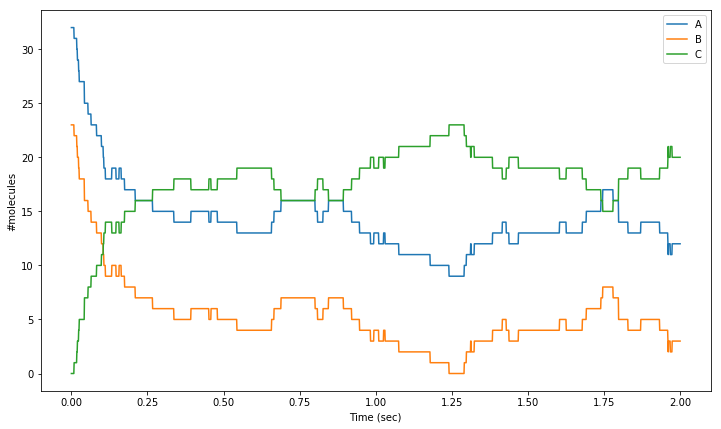

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
# Plot number of molecules of 'molA' over the time range:
plt.plot(tpnt, res[:,0], label = 'A')
# Plot number of molecules of 'molB' over the time range:
plt.plot(tpnt, res[:,1], label = 'B')
# Plot number of molecules of 'molC' over the time range:
plt.plot(tpnt, res[:,2], label = 'C')
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend()
plt.show()

If we're using a stochastic simulation algorithm such as that implemented in
solver `Wmdirect`, we're usually interested in analysing the range of behaviours
produced by different iterations. One way of doing that is by taking the mean
over multiple iterations (100 in this example), as is shown in the following
simulation code. We plot the average of multiple (n = 100) iterations of our second order reaction.

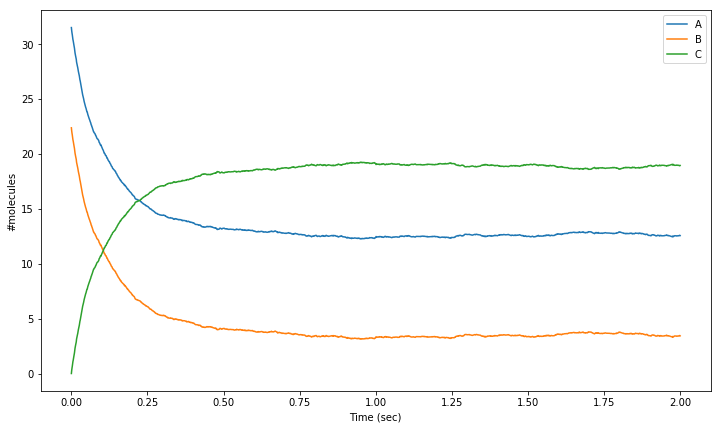

In [18]:
NITER = 100
res = numpy.zeros([NITER, 2001, 3])
tpnt = numpy.arange(0.0, 2.001, 0.001)

for i in range(0, NITER):
    sim.reset()
    sim.setCompConc('comp', 'molA', 31.4e-6)
    sim.setCompConc('comp', 'molB', 22.3e-6)

    for t in range(0, 2001):
        sim.run(tpnt[t])
        res[i, t, 0] = sim.getCompCount('comp', 'molA')
        res[i, t, 1] = sim.getCompCount('comp', 'molB')
        res[i, t, 2] = sim.getCompCount('comp', 'molC')
res_mean = numpy.mean(res, 0)

plt.figure(figsize=(12,7))
# Plot mean number of molecules of 'molA' over the time range:
plt.plot(tpnt, res_mean[:,0], label = 'A')
# Plot mean number of molecules of 'molB' over the time range:
plt.plot(tpnt, res_mean[:,1], label = 'B')
# Plot mean number of molecules of 'molC' over the time range:
plt.plot(tpnt, res_mean[:,2], label = 'C')

plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend()

As you can see, the array that will be used to store the simulation results
(array res) is now a three dimensional array, with the first dimension set to
record 100 iterations. The loop that runs over all time points is now embedded
in a loop that runs over the iterations. The solver object is reset and the initial
conditions are set at the beginning of each iteration. Since we don't need
any detailed control over which iteration starts with which RNG seed value,
we initialize the RNG just once, prior to everything else. Once the 100 iterations
are completed, we call NumPy's mean function to compute the mean over the first
dimension, and then plot these mean values.

## Controlling the simulation

In the previous section, we paused the simulation at regular time intervals
only to record the concentrations of various molecules. The only time we actively
changed the simulation state was at t=0, to set the initial conditions. However,
the function calls we used to set initial conditions can be called at any time
during the simulation.

As an example, let's interrupt our simulation at t=1sec to add 10 molecules
of species molA. We plot the mean behaviour   of multiple (n = 100) iterations of our second order reaction, with an injection of 10 molecules of species A at t = 1.0.


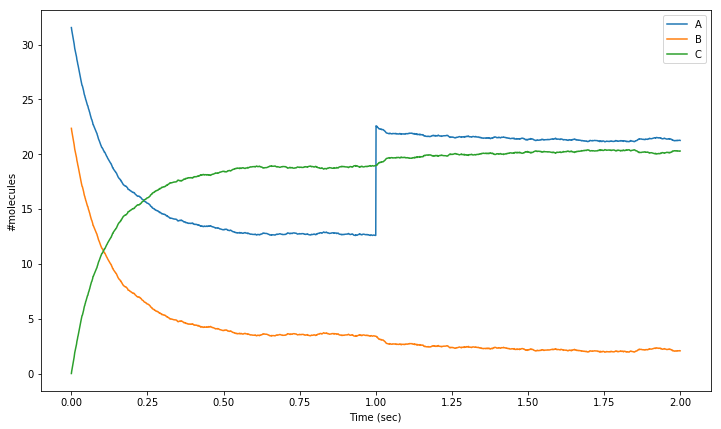

In [19]:
for i in range(NITER):
    sim.reset()
    sim.setCompConc('comp', 'molA', 31.4e-6)
    sim.setCompConc('comp', 'molB', 22.3e-6)

    for t in range(0,1001):
        sim.run(tpnt[t])
        res[i, t, 0] = sim.getCompCount('comp', 'molA')
        res[i, t, 1] = sim.getCompCount('comp', 'molB')
        res[i, t, 2] = sim.getCompCount('comp', 'molC')

    # Add 10 molecules of species A
    sim.setCompCount('comp', 'molA', sim.getCompCount('comp', 'molA') + 10)
    for t in range(1001, 2001):
        sim.run(tpnt[t])
        res[i, t, 0] = sim.getCompCount('comp', 'molA')
        res[i, t, 1] = sim.getCompCount('comp', 'molB')
        res[i, t, 2] = sim.getCompCount('comp', 'molC')

res_mean = numpy.mean(res, 0)

plt.figure(figsize=(12,7))
# Plot mean number of molecules of 'molA' over the time range:
plt.plot(tpnt, res_mean[:,0], label = 'A')
# Plot mean number of molecules of 'molB' over the time range:
plt.plot(tpnt, res_mean[:,1], label = 'B')
# Plot mean number of molecules of 'molC' over the time range:
plt.plot(tpnt, res_mean[:,2], label = 'C')

plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend()

When you have to do these things regularly, you might want to encapsulate
various parts of this code in separate functions to save yourself some coding time.

Quite often, one does not want to simulate the sudden injection of molecules,
but rather keep the concentration of some species constant at a controlled value.
This means that any reaction involving the buffered molecule will still occur
if the reactants are present in sufficiently large numbers, but the occurrence
of this reaction will not actually change the amount of the buffered species
that is present. The following code snippet shows how, during the time
interval $0.1\leq t<0.6$, the concentration of species `molA` is clamped to
whatever its value was at $t=0.5$. We plot the result of a single iteration of the second order reaction, where the concentration of A is clamped during the interval $0.1\leq t<0.6$


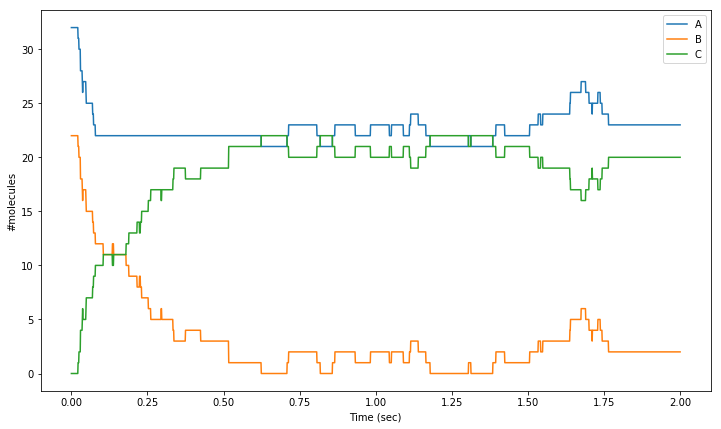

In [20]:
for i in range(1):
    sim.reset()
    sim.setCompConc('comp', 'molA', 31.4e-6)
    sim.setCompConc('comp', 'molB', 22.3e-6)

    for t in range(0, 101):
        sim.run(tpnt[t])
        res[i, t, 0] = sim.getCompCount('comp', 'molA')
        res[i, t, 1] = sim.getCompCount('comp', 'molB')
        res[i, t, 2] = sim.getCompCount('comp', 'molC')

    sim.setCompClamped('comp', 'molA', True)

    for t in range(101, 601):
        sim.run(tpnt[t])
        res[i, t, 0] = sim.getCompCount('comp', 'molA')
        res[i, t, 1] = sim.getCompCount('comp', 'molB')
        res[i, t, 2] = sim.getCompCount('comp', 'molC')

    sim.setCompClamped('comp', 'molA', False)

    for t in range(601,2001):
        sim.run(tpnt[t])
        res[i, t, 0] = sim.getCompCount('comp', 'molA')
        res[i, t, 1] = sim.getCompCount('comp', 'molB')
        res[i, t, 2] = sim.getCompCount('comp', 'molC')

res = res[0,:,:]

plt.figure(figsize=(12,7))
# Plot mean number of molecules of 'molA' over the time range:
plt.plot(tpnt, res[:,0], label='A')
# Plot mean number of molecules of 'molB' over the time range:
plt.plot(tpnt, res[:,1], label='B')
# Plot mean number of molecules of 'molC' over the time range:
plt.plot(tpnt, res[:,2], label='C')

plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend()

The function [steps.solver.Wmdirect.setCompClamped](API_solver.rst#steps.solver.Wmdirect.setCompClamped) takes a boolean which is used to turn on or off
the clamping of the species in the specified compartment.

A final way in which we will control our simulation in this chapter is
by activating/inactivating a reaction channel. Inactivating a reaction channel
means that it will never occur, regardless of whether the required reactants
are present in sufficient numbers. In the following simulation:

* we will turn off the forward reaction of the above equation  during
  interval $2.0\leq t<4.0$;

* turn it back on and let everything recover during $4.0\leq t<6.0$;

* turn off the backward reaction during $6.0\leq t<8.0$;

* turn it back on and let everything recover again during $8.0\leq t<10.0$;

* and finally turn off both the forward and backward channel during a final
  interval $10.0\leq t<12.0$.

This time, we'll wrap the “run-until-time-t“ part of the code in a separate
function to save ourselves some writing, and we also have to alter our `tpnt`
and `res` arrays to store data for 12 seconds:


In [21]:
def run(i, tp1, tp2):
    for t in range(tp1, tp2):
        sim.run(tpnt[t])
        res[i,t,0] = sim.getCompCount('comp', 'molA')
        res[i,t,1] = sim.getCompCount('comp', 'molB')
        res[i,t,2] = sim.getCompCount('comp', 'molC')
res = numpy.zeros([NITER, 12001, 3])
tpnt = numpy.arange(0.0, 12.001, 0.001)

The actual simulation code now becomes:


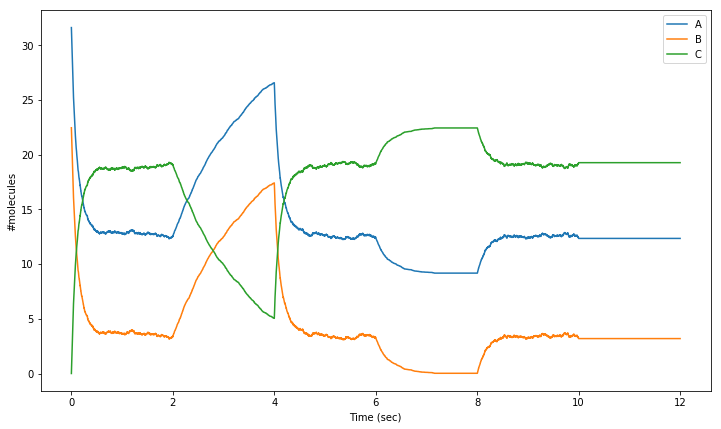

In [22]:
for i in range(NITER):
    sim.reset()
    sim.setCompConc('comp', 'molA', 31.4e-6)
    sim.setCompConc('comp', 'molB', 22.3e-6)
    run(i,0,2001)
    sim.setCompReacActive('comp', 'kreac_f', False)
    run(i,2001,4001)
    sim.setCompReacActive('comp', 'kreac_f', True)
    run(i,4001,6001)
    sim.setCompReacActive('comp', 'kreac_b', False)
    run(i,6001,8001)
    sim.setCompReacActive('comp', 'kreac_b', True)
    run(i,8001,10001)
    sim.setCompReacActive('comp', 'kreac_f', False)
    sim.setCompReacActive('comp', 'kreac_b', False)
    run(i,10001,12001)
    

res_mean = numpy.mean(res, 0)

plt.figure(figsize=(12,7))
# Plot mean number of molecules of 'molA' over the time range:
plt.plot(tpnt, res_mean[:,0], label = 'A')
# Plot mean number of molecules of 'molB' over the time range:
plt.plot(tpnt, res_mean[:,1], label = 'B')
# Plot mean number of molecules of 'molC' over the time range:
plt.plot(tpnt, res_mean[:,2], label = 'C')

plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend()